In [3]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import os
import pickle
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical

# **Load processed data**

In [8]:
import pandas as pd
fraud_data = pd.read_csv('/content/drive/MyDrive/fraud detection/data/preprocessed_data.csv')
creditcard_data = pd.read_csv('/content/drive/MyDrive/fraud detection/data/credit_card_preprocessed_data.csv')
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,transaction_count,hour_of_day,...,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,country_encoded
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160088,QVPSPJUOCKZAR,39,732758368,0,0.0,2,...,0,1,1,0,0,0,0,0,1,0.056572
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142743,EOGFQPIZPYXFZ,53,350311387,0,0.0,1,...,0,0,1,0,0,0,0,1,0,0.449484
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197335,YSSKYOSJHPPLJ,53,2621473820,1,0.0,18,...,0,1,0,0,0,1,0,0,1,0.449484
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112871,NAUITBZFJKHWW,45,415583117,0,0.0,18,...,0,0,0,0,0,0,1,0,1,0.449484
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,0.276647,ALEYXFXINSXLZ,18,2809315199,0,0.0,8,...,0,0,1,0,0,0,0,0,1,0.023036


# **Data Preparation:**
Feature and Target Separation [‘Class’(creditcard), ‘class’(Fraud_Data)]


Train-Test Split

In [11]:
def split_data(df):
            X = df.drop(['user_id', 'signup_time', 'purchase_time','device_id','ip_address','class'],axis = 1)
            y = df['class']

            # Split the dataset into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            return X_train, X_test, y_train, y_test


In [12]:
X_train, X_test, y_train, y_test = split_data(fraud_data)

# **Training function**

In [15]:
def train_with_ml_model(X_train, X_test, y_train, y_test, model_name):
            # Enable autologging
            mlflow.sklearn.autolog()

            with mlflow.start_run(run_name=f"fraud_data_{model_name}_model"):
                # Model training
                if model_name=="LogisticRegression":
                    model = LogisticRegression(max_iter=100)
                elif model_name=="RandomForestClassifier":
                    model = RandomForestClassifier(n_estimators=100, random_state=42)
                elif model_name=="DecisionTreeClassifier":
                    model = DecisionTreeClassifier(max_depth=3, random_state=42)
                elif model_name=="GradientBoostingClassifier":
                    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
                elif model_name=="MLPClassifier":
                    model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.001, solver='adam', random_state=42)
                elif model_name == "CNN":
                    model = Sequential([
                        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
                        MaxPooling1D(2),
                        Flatten(),
                        Dense(100, activation='relu'),
                        Dense(1, activation='sigmoid')
                    ])
                    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                elif model_name == "RNN":
                    model = Sequential([
                        SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),
                        Dense(1, activation='sigmoid')
                    ])
                    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                elif model_name == "LSTM":
                    model = Sequential([
                        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
                        Dense(1, activation='sigmoid')
                    ])
                    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

                # Reshape data for deep learning models
                if model_name in ["CNN", "RNN", "LSTM"]:
                    # X_train, X_test = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
                    X_train = np.array(X_train).reshape((-1, X_train.shape[1], 1))
                    X_test = np.array(X_test).reshape((-1, X_test.shape[1], 1))

                # model.fit(X_train, y_train)

                # # Predict on the test set
                # y_pred = model.predict(X_test)
                # y_pred_proba = model.predict_proba(X_test)

                # Train the model
                if model_name in ["CNN", "RNN", "LSTM"]:
                    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
                    y_pred_proba = model.predict(X_test)
                    y_pred = (y_pred_proba > 0.5).astype(int)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None


                # Evaluate the model
                accuracy = accuracy_score(y_test, y_pred)
                print(f"Accuracy: {accuracy}")

                # Log parameters and metrics manually
                mlflow.log_metric("accuracy", accuracy)

                # Log the model to MLflow
                mlflow.sklearn.log_model(model, f"{model_name}_model")

                # Log parameters
                # mlflow.log_param("max_iter", 100)
                # mlflow.log_param("solver", "lbfgs")

                # Confusion Matrix
                cm = confusion_matrix(y_test, y_pred)

                # Plot confusion matrix
                plt.figure(figsize=(6,6))
                class_names=['1','0']
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.title('Confusion Matrix')
                plt.show()

                # Save the confusion matrix plot
                cm_plot_path = f"/content/drive/MyDrive/fraud detection/data/{model_name}_confusion_matrix.png"
                plt.savefig(cm_plot_path)
                mlflow.log_artifact(cm_plot_path)

                # ROC Curve
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 0], pos_label=0)
                roc_auc = auc(fpr, tpr)

                # Plot ROC curve
                plt.figure()
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('Receiver Operating Characteristic')
                plt.legend(loc="lower right")
                plt.show()

                # Save the ROC curve plot
                roc_plot_path = f"/content/drive/MyDrive/fraud detection/data/{model_name}_roc_curve.png"
                plt.savefig(roc_plot_path)
                mlflow.log_artifact(roc_plot_path)

                # Print the run ID for reference
                run_id = mlflow.active_run().info.run_id
                print(f"Run ID: {run_id}")

                #Save the model in .pkl format
                # Create the folder if it doesn't exist
                folder_path='/content/drive/MyDrive/fraud detection/models/fraud_data/'
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                # Generate timestamp in format dd-mm-yyyy-HH-MM-SS-00
                timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S-00")

                # Create a filename with the timestamp
                filename = f'{folder_path}{model_name}-{timestamp}.pkl'

                # Save the model using pickle
                with open(filename, 'wb') as file:
                    pickle.dump(model, file)

                print(f"Model saved as {filename}")

# **Logistic Regression**

2025/02/17 21:26:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

Accuracy: 0.9039335122857732


2025/02/17 21:26:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


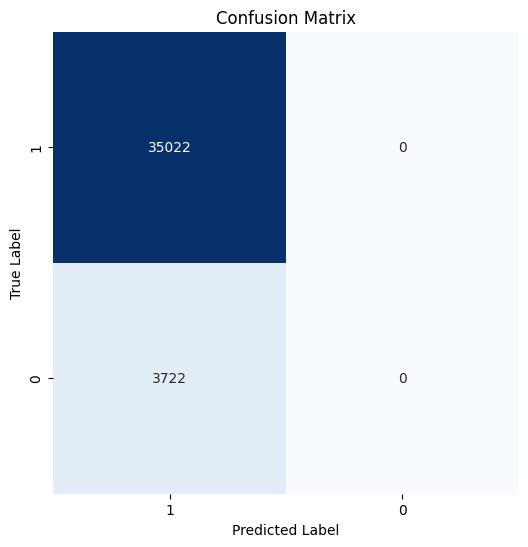

<Figure size 640x480 with 0 Axes>

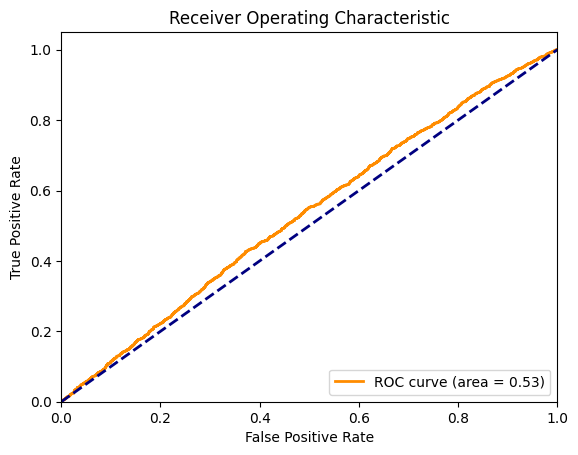

Run ID: d3601a8c44f842789ca7f16f22645605
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/LogisticRegression-17-02-2025-21-26-58-00.pkl


<Figure size 640x480 with 0 Axes>

In [16]:
train_with_ml_model(X_train, X_test, y_train, y_test,"LogisticRegression")

# **DecisionTreeClassifier model**

2025/02/17 21:48:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels 

Accuracy: 0.9039335122857732


2025/02/17 21:48:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


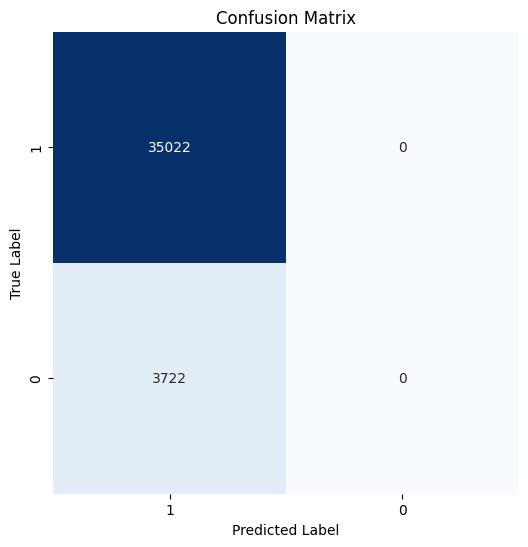

<Figure size 640x480 with 0 Axes>

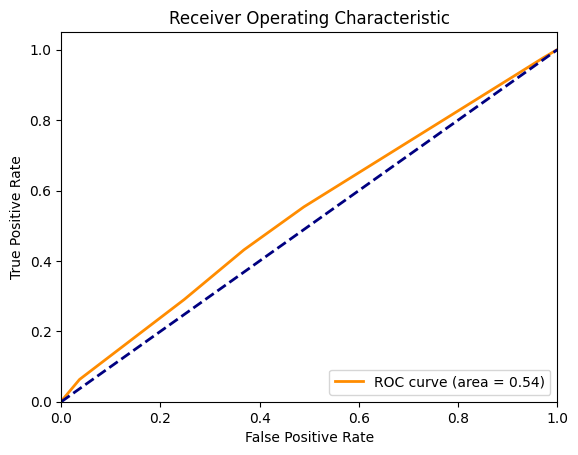

Run ID: 28b3d2c963d8457cb4566c1f79523332
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/DecisionTreeClassifier-17-02-2025-21-48-33-00.pkl


<Figure size 640x480 with 0 Axes>

In [24]:
train_with_ml_model(X_train, X_test, y_train, y_test,"DecisionTreeClassifier")

# **RandomForestClassifie**

2025/02/17 21:28:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/02/17 21:28:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils

Accuracy: 0.9543929382614083


2025/02/17 21:28:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


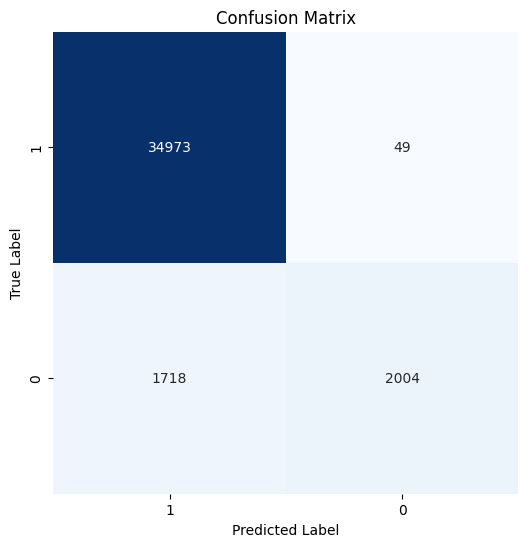

<Figure size 640x480 with 0 Axes>

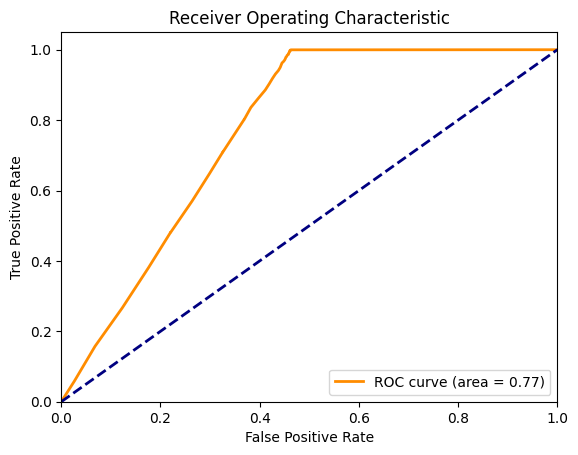

Run ID: 2b9db31e5cf1417683747c782d9131c6
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/RandomForestClassifier-17-02-2025-21-28-43-00.pkl


<Figure size 640x480 with 0 Axes>

In [17]:
train_with_ml_model(X_train, X_test, y_train, y_test,"RandomForestClassifier")

# **GradientBoostingClassifier model**

2025/02/17 21:29:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/02/17 21:29:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils

Accuracy: 0.9039335122857732


2025/02/17 21:29:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


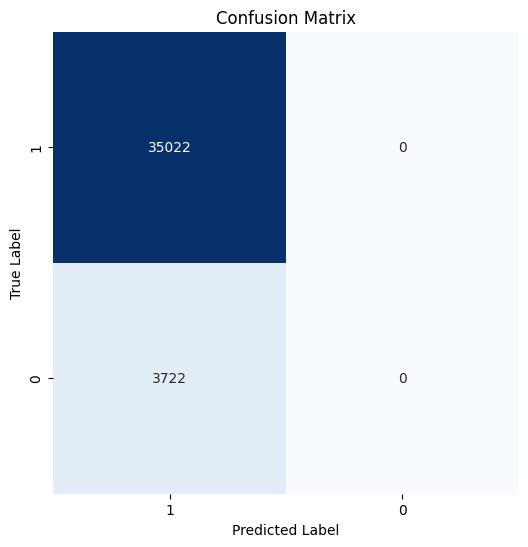

<Figure size 640x480 with 0 Axes>

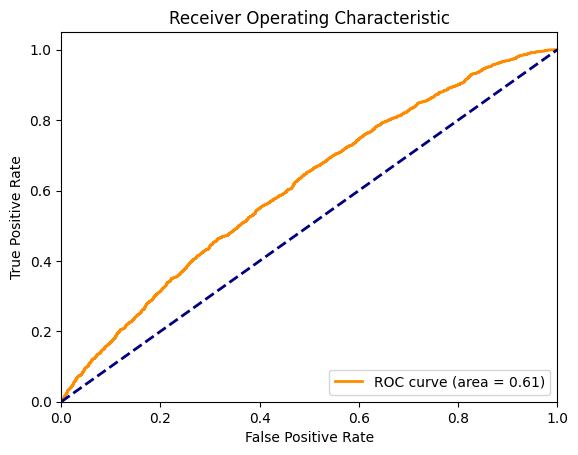

Run ID: 5a2d4e1f31014843b2d363cb0a0873c3
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/GradientBoostingClassifier-17-02-2025-21-29-57-00.pkl


<Figure size 640x480 with 0 Axes>

In [18]:
train_with_ml_model(X_train, X_test, y_train, y_test,"GradientBoostingClassifier")

# **MLPClassifier model**

2025/02/17 21:30:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/02/17 21:36:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils

Accuracy: 0.9039077018377039


2025/02/17 21:36:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


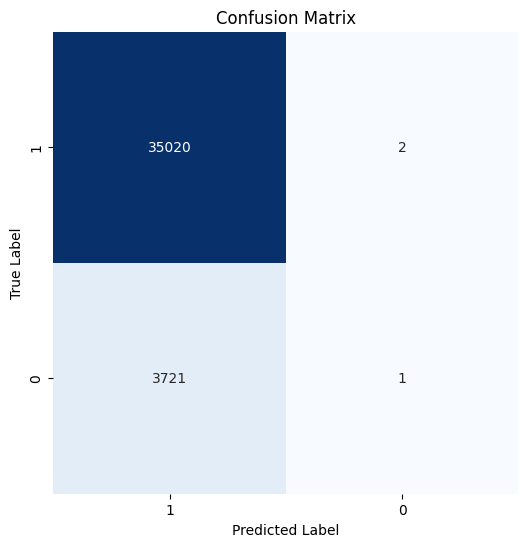

<Figure size 640x480 with 0 Axes>

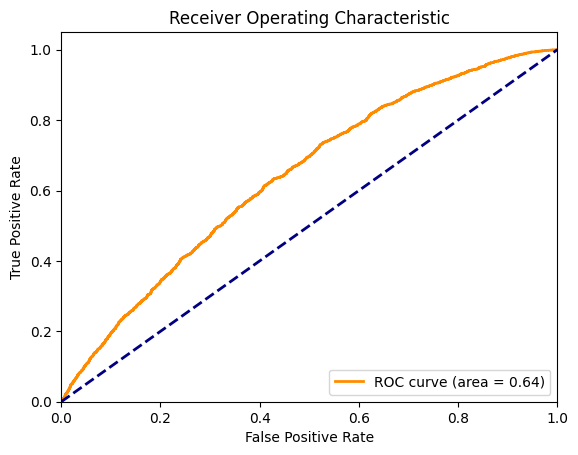

Run ID: ebfebdf287334ba999c2febb0a7012cf
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/MLPClassifier-17-02-2025-21-36-20-00.pkl


<Figure size 640x480 with 0 Axes>

In [20]:
train_with_ml_model(X_train, X_test, y_train, y_test,"MLPClassifier")

# **CNN model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9006 - loss: 0.3318 - val_accuracy: 0.9056 - val_loss: 0.3140
Epoch 2/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9046 - loss: 0.3169 - val_accuracy: 0.9056 - val_loss: 0.3149
Epoch 3/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9050 - loss: 0.3151 - val_accuracy: 0.9056 - val_loss: 0.3177
Epoch 4/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9043 - loss: 0.3163 - val_accuracy: 0.9056 - val_loss: 0.3121
Epoch 5/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9064 - loss: 0.3111 - val_accuracy: 0.9056 - val_loss: 0.3130
Epoch 6/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9070 - loss: 0.3094 - val_accuracy: 0.9056 - val_loss: 0.3140
Epoch 7/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9070 - loss: 0.3090 - val_accuracy: 0.9056 - val_loss: 0.3123
Epoch 8/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9067 - loss: 0.30

2025/02/17 21:38:24 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-01-14; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-spark-connect'}
2025/02/17 21:38:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


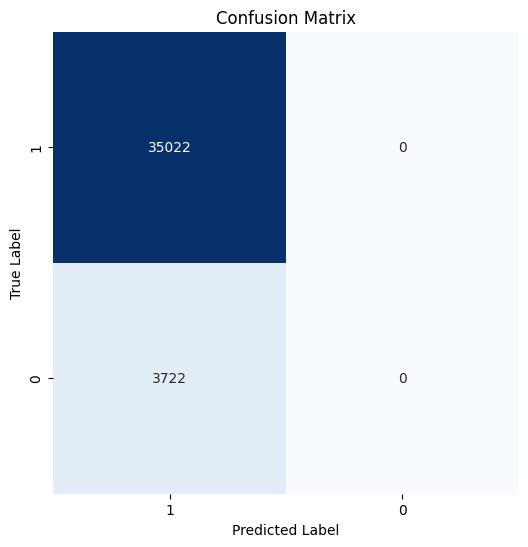

<Figure size 640x480 with 0 Axes>

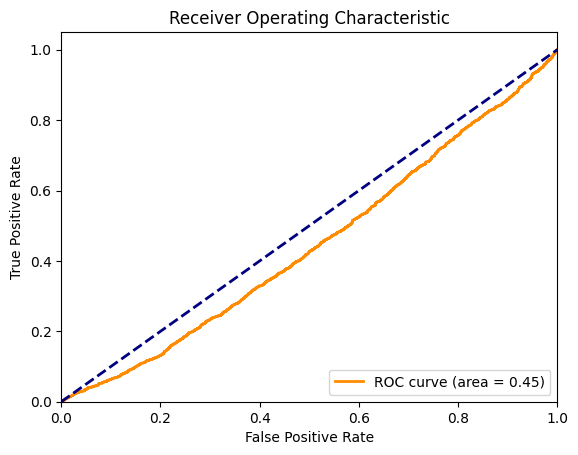

Run ID: 1841cade6b314591885bc858bd7c2d59
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/CNN-17-02-2025-21-38-24-00.pkl


<Figure size 640x480 with 0 Axes>

In [21]:
train_with_ml_model(X_train, X_test, y_train, y_test,"CNN")

# **RNN model**

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2261/2261 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9001 - loss: 0.3333 - val_accuracy: 0.9056 - val_loss: 0.3177
Epoch 2/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9064 - loss: 0.3131 - val_accuracy: 0.9056 - val_loss: 0.3125
Epoch 3/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9046 - loss: 0.3156 - val_accuracy: 0.9056 - val_loss: 0.3127
Epoch 4/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9056 - loss: 0.3129 - val_accuracy: 0.9056 - val_loss: 0.3128
Epoch 5/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9057 - loss: 0.3130 - val_accuracy: 0.9056 - val_loss: 0.3134
Epoch 6/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9042 - loss: 0.3158 - val_accuracy: 0.9056 - val_loss: 0.3125
Epoch 7/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9060 - loss: 0.3118 - val_accuracy: 0.9056 - val_loss: 0.3124
Epoch 8/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9068 - loss: 0.3097 - va

2025/02/17 21:41:48 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-01-14; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-spark-connect'}
2025/02/17 21:41:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


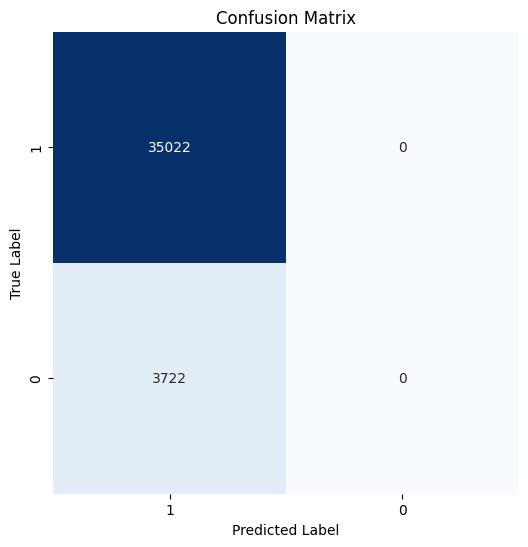

<Figure size 640x480 with 0 Axes>

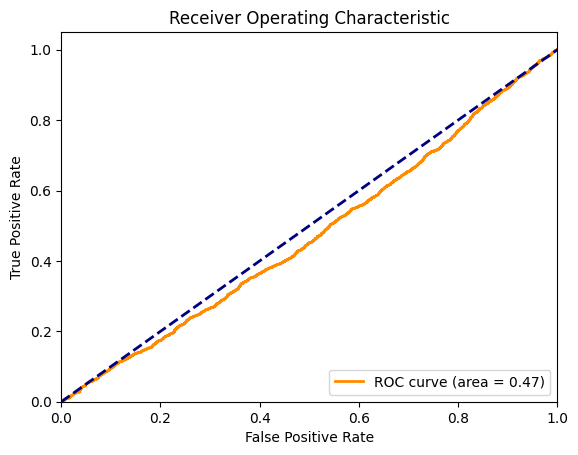

Run ID: 3d7382e9f8514fc0b2f4cae816b17c63
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/RNN-17-02-2025-21-41-49-00.pkl


<Figure size 640x480 with 0 Axes>

In [22]:
train_with_ml_model(X_train, X_test, y_train, y_test,"RNN")

# **LSTM model**

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2261/2261 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.9054 - loss: 0.3299 - val_accuracy: 0.9056 - val_loss: 0.3137
Epoch 2/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9050 - loss: 0.3149 - val_accuracy: 0.9056 - val_loss: 0.3125
Epoch 3/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9044 - loss: 0.3160 - val_accuracy: 0.9056 - val_loss: 0.3123
Epoch 4/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9073 - loss: 0.3091 - val_accuracy: 0.9056 - val_loss: 0.3123
Epoch 5/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9051 - loss: 0.3139 - val_accuracy: 0.9056 - val_loss: 0.3134
Epoch 6/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9040 - loss: 0.3166 - val_accuracy: 0.9056 - val_loss: 0.3122
Epoch 7/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9047 - loss: 0.3148 - val_accuracy: 0.9056 - val_loss: 0.3125
Epoch 8/10
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9044 - loss: 0.31

2025/02/17 21:48:19 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-01-14; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-spark-connect'}
2025/02/17 21:48:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


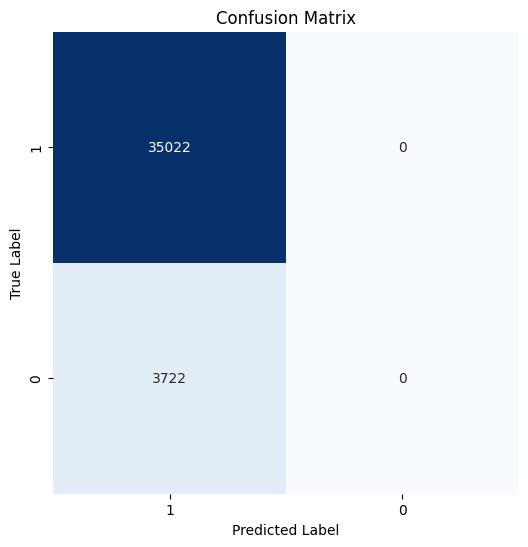

<Figure size 640x480 with 0 Axes>

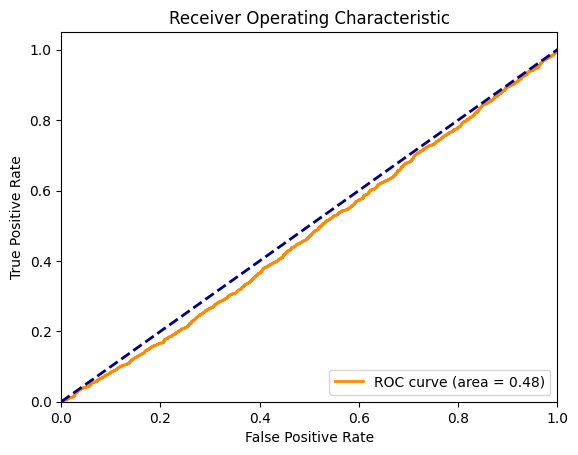

Run ID: 294df19537a24c99ac40df21e73d886b
Model saved as /content/drive/MyDrive/fraud detection/models/fraud_data/LSTM-17-02-2025-21-48-19-00.pkl


<Figure size 640x480 with 0 Axes>

In [23]:
train_with_ml_model(X_train, X_test, y_train, y_test,"LSTM")